In [1]:
import numpy as np
import qiskit as qk
from qiskit.circuit.library import TwoLocal
import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize as OPT
from IPython.display import display

In [2]:
## Parameters for the quantum computer
backend = qk.Aer.get_backend('qasm_simulator')
num_shots=1000

In this Homework, we explore the use of Variational Quantum Eigensolvers to estimate the ground state energy of the di-Hydrogen molecule (H$_2$). As discussed in the Homework Problem, the Hamiltonian for molecular Hydrogen can be reduced to the following,
\begin{align}
\hat{H}=g_0 I +g_1 \sigma^z_1 + g_2 \sigma^z_2 +g_3 \sigma^z_1 \sigma^z_2 +g_4 \sigma^y_1 \sigma^y_2 +g_5 \sigma^x_1 \sigma^x_2
\end{align}
The parameters, $g_{j}$, $j=0,1\cdots 5$ are real numbers that depend on the bond length $R$ of the molecule. The numerical values of the parameters as a function $R$ are provided in the accompanying table `g_values.csv`.

In [3]:
# Extract parameters from the provided table taken from the paper
data=np.genfromtxt('g_values.csv',delimiter=',')
H2_data={'R':data[1:,0],
         'g0':data[1:,1],
         'g1':data[1:,2],
         'g2':data[1:,3],
         'g3':data[1:,4],
         'g4':data[1:,6],
         'g5':data[1:,5],
        }
p=10
print("""For example, for bond distance, R=%.2f, 
we have the parameters:(g0,g1,g2,g3,g4,g5):(%.2f,%.2f,%.2f,%.2f,%.2f,%.2f)
      """%(H2_data['R'][p],
             H2_data['g0'][p],
             H2_data['g1'][p],
             H2_data['g2'][p],
             H2_data['g3'][p],
             H2_data['g4'][p],
             H2_data['g5'][p],
          )
     )

For example, for bond distance, R=0.70, 
we have the parameters:(g0,g1,g2,g3,g4,g5):(0.30,0.36,-0.48,0.58,0.09,0.09)
      


# Classical Simulation of H$_2$
We have provided the classical simulation for you to verify your VQE algorithm against. This was used to generate the Figure 1. in the problem set

In [4]:
# We provide the classical solution for the problem.
def classically_simulate_H2_groundstate(gvals):
    si = qt.qeye(2)
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()
    Id=qt.tensor(qt.qeye(2),qt.qeye(2))
    ZI=qt.tensor(qt.sigmaz(),qt.qeye(2))
    IZ=qt.tensor(qt.qeye(2),qt.sigmaz())
    ZZ=qt.tensor(qt.sigmaz(),qt.sigmaz())
    YY=qt.tensor(qt.sigmay(),qt.sigmay())
    XX=qt.tensor(qt.sigmaz(),qt.sigmaz())
    
    # construct the hamiltonian
    H = (gvals['g0']*Id+gvals['g1']*ZI+
         gvals['g2']*IZ+gvals['g3']*ZZ+
         gvals['g4']*YY+gvals['g5']*XX)
    energy,state=H.groundstate()
    return energy

We would like to replicate this figure using the VQE algorithm:


Text(0.5, 1.0, 'Ground state energy vs Bond-length')

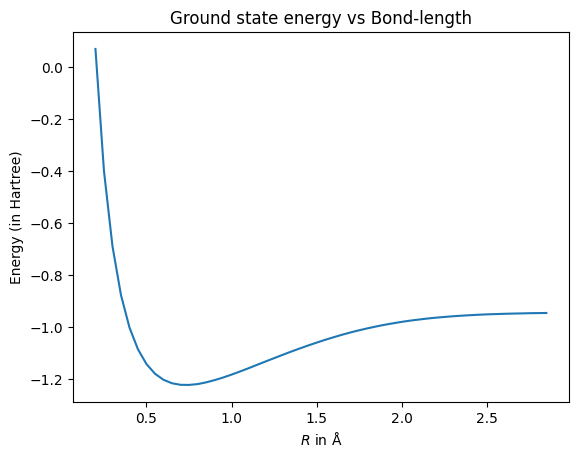

In [5]:
gstate_energies=[]
for p in range(len(H2_data['R'])):
    gvals={'g0':H2_data['g0'][p],
           'g1':H2_data['g1'][p],
           'g2':H2_data['g2'][p],
           'g3':H2_data['g3'][p],
           'g4':H2_data['g4'][p],
           'g5':H2_data['g5'][p],
            }
    gstate_energies.append(classically_simulate_H2_groundstate(gvals))
print('We would like to replicate this figure using the VQE algorithm:')
plt.plot(H2_data['R'],gstate_energies);
plt.ylabel('Energy (in Hartree)')
plt.xlabel('$R$ in Å')
plt.title('Ground state energy vs Bond-length')

# Variational Ansatz for H$_2$ molecule 

In this section, you will complete a function that implements the variational ansatz for the H2 molecule. Recall that the Ansatz prepares the Hartree Fock initial state and applies the UCCSD ansatz.
\begin{align}
|\psi(\theta)\rangle=e^{-i\Theta {\hat{Y}_1\hat{X}_2}}|10\rangle
\end{align}

In [15]:
def create_UCC_ansatz(qr,cr):
    """Create circuit with the UCC Ansatz using THETA which 
       is a Parameter variable defined in qiskit
    """
    # Create registers
    circ = qk.QuantumCircuit(qr, cr)
    THETA=qk.circuit.Parameter('θ')
    # Apply ansatz
    #######################
    circ.x(0)
    circ.rx(-np.pi/2,0)
    circ.ry(+np.pi/2,1)
    
    circ.cx(0,1)
    circ.rz(THETA, 1)
    circ.cx(0,1)
    
    circ.rx(+np.pi/2,0)
    circ.ry(-np.pi/2,1)
    #######################
    
    return circ

UCC Ansatz


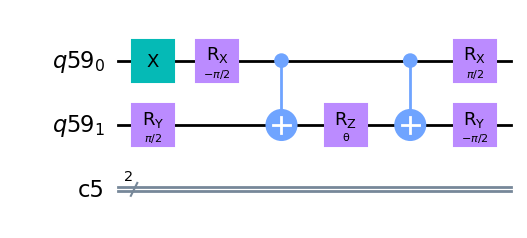

In [16]:
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ1=create_UCC_ansatz(qr,cr)
# check that the circuit is drawn correctly
print('UCC Ansatz')
display(circ1.draw('mpl'))

# Measuring Expectation Value of the Hamiltonian

Next we set up functions to measure along $x$ $y$ and $z$ basis which we then use to measure the expectation value of the Hamiltonian described at the top.

Recall that we are interested in the following Hamiltonian
\begin{align}
\hat{H}=g_0 I +g_1 \sigma^z_1 + g_2 \sigma^z_2 +g_3 \sigma^z_1 \sigma^z_2 +g_4 \sigma^y_1 \sigma^y_2 +g_5 \sigma^x_1 \sigma^x_2
\end{align}

We define functions that measure in the $x$, $y$ and $z$ basis. These functions take in a quantum circuit object as input and return a circuit with measurements applied on all qubits in the $x$ $y$ and $z$ directions. 

In [17]:
def measurement_circuits(circ):
    '''
    Takes as input a circuit and
    returns a list of circuits that measures along x, y and z
    '''
    circ_x=circ.copy()
    circ_x.name=circ_x.name+'-x'
    
    qr_x = circ_x.qubits
    cr_x = circ_x.clbits
    
    circ_x.h(qr_x)
    circ_x.measure(qr_x, cr_x)
    
    #############################
    
    circ_y=circ.copy()
    circ_y.name=circ_y.name+'-y'
    
    qr_y = circ_y.qubits
    cr_y = circ_y.clbits
    
    circ_y.sdg(qr_y)
    circ_y.h(qr_y)
    circ_y.measure(qr_y, cr_y)
    
    #############################

    circ_z=circ.copy()
    circ_z.name=circ_z.name+'-z'
    
    qr_z = circ_z.qubits
    cr_z = circ_z.clbits
    
    circ_z.measure(qr_z, cr_z)

    return [circ_x,circ_y,circ_z]


def calculate_probabilities_after_measurement(circ):
    '''
    Takes in a circuit (non parameterized) executes it with measurements along x, y and z,
    and returns the measurement outcome probabilities of the bitstrings in that basis
    '''
    circ_measured=measurement_circuits(circ)
    job = qk.execute(circ_measured, backend=backend,shots=num_shots)
    result = job.result()
    result_counts_x=result.get_counts(circ_measured[0].name)
    result_counts_y=result.get_counts(circ_measured[1].name)
    result_counts_z=result.get_counts(circ_measured[2].name)
    px_dict= {key:result_counts_x[key]/num_shots for key in result_counts_x}
    py_dict= {key:result_counts_y[key]/num_shots for key in result_counts_y} 
    pz_dict= {key:result_counts_z[key]/num_shots for key in result_counts_z}
    return [px_dict,py_dict,pz_dict]

def calculate_expectation_value(circ_bound,g_vals):
    '''
    Takes in a circuit (circ_bound) with a value bound to the parameter, 
    performs measurements and returns the expectation value.
    It should calculate the expectation value using the dictionary g_vals, that has the parameters
    gvals={'g0':,'g1':,'g2':,'g3':,'g4':, 'g5':}
    '''
    
    px,py,pz=calculate_probabilities_after_measurement(circ_bound) 
    
    H_expectval= (g_vals['g0']+
                  g_vals['g1']* (pz.get('00', 0) - pz.get('01', 0)+ pz.get('10', 0) - pz.get('11', 0))+
                  g_vals['g2']* (pz.get('00', 0) + pz.get('01', 0)-pz.get('10', 0) - pz.get('11', 0))+
                  g_vals['g3']* (pz.get('00', 0) - pz.get('01', 0)- pz.get('10', 0) + pz.get('11', 0))+  
                  g_vals['g4']* (py.get('00', 0) - py.get('01', 0)-py.get('10', 0) + py.get('11', 0))+
                  g_vals['g5']* (px.get('00', 0) - px.get('01', 0)- px.get('10', 0) + px.get('11', 0)))
    return H_expectval

## Check
Test the expectation value function for the first set of parameters in the data dictionary. If you got your circuits and measurments correctly for the UCC ansatz, the Energy for $R=0.2$Å at $\theta=0$ of the H2 ansatz should be around 0.15 Hartree.

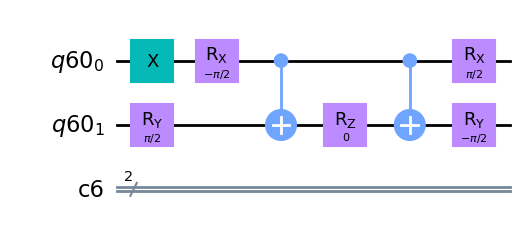

Expected value of energy of H2 molecule for R=0.20Å and θ=0.00 rads is 0.16 Hartree


In [18]:
# Compute for the first row of parameters, for THETA=0 in the UCC Ansatz (corresponds to R=0.2)
p=0
gvals={'g0':H2_data['g0'][p],
       'g1':H2_data['g1'][p],
       'g2':H2_data['g2'][p],
       'g3':H2_data['g3'][p],
       'g4':H2_data['g4'][p],
       'g5':H2_data['g5'][p],
        }

theta_val=0

qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ=create_UCC_ansatz(qr,cr)
circ_bound=circ.bind_parameters({circ.parameters[0]:theta_val}) # binds the value theta_val to the parameter in the circuit
display(circ_bound.draw('mpl'))
H_val=calculate_expectation_value(circ_bound,gvals)
print('Expected value of energy of H2 molecule for R=%.2fÅ and θ=%.2f rads is %.2f Hartree'%(H2_data['R'][p],theta_val,H_val))

# Classical Optimization loop : Exhaustive Search

Now that we have set up the variational ansatz, and the measurements necessary to calculate the expectation value, we finally need to optimize over the anglesto find the optimal parameter that minimizes the measured expectation value. We will exhaustively search to find the optimal parameter for the variational circuit

In [20]:
def exhaustive_search(circ_parametrized,gvals,theta_lb,theta_ub):
    '''
    Exhaustively searches over 100 different values of parameters between theta_lb and theta_ub to
    find optimal value of θ.
    Takes as input a parameterized circuit, bind a value of theta to it and calculate the expectation value.
    '''
    theta_vals=np.linspace(theta_lb,theta_ub,100) # 100 different angles between θmin and θmax
    H_vals=[]
    
    theta_min = theta_lb
    H_min = 1e6
    
    for theta_val in theta_vals:
        circ_bound = circ.bind_parameters({circ.parameters[0]:theta_val})
        H_val = calculate_expectation_value(circ_bound,gvals)
        
        if H_val < H_min:
            H_min = H_val
            theta_min = theta_val        
    
    return theta_min,H_min



Next, test the optimization routine by using an example set of parameters.

In [21]:
#conditions on parameters
p=20
gvals={'g0':H2_data['g0'][p],
       'g1':H2_data['g1'][p],
       'g2':H2_data['g2'][p],
       'g3':H2_data['g3'][p],
       'g4':H2_data['g4'][p],
       'g5':H2_data['g5'][p],
        }

#define variational circuit
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ=create_UCC_ansatz(qr,cr)

theta_min,H_min=exhaustive_search(circ,gvals,0,np.pi)
print(' Expected value of energy of H2 molecule for R=%.2fÅ  is minimum (using exhaustive search) at and θ=%.2f rads and is %.3f Hartree'%(H2_data['R'][p],theta_min,H_min))


 Expected value of energy of H2 molecule for R=1.20Å  is minimum (using exhaustive search) at and θ=0.48 rads and is -1.071 Hartree


# Bringing it all together to obtain Ground state Energy vs Bond length for H$_2$

Now, we use the exhaustive search to optimize for different bond lengths to reproduce the energy vs bond angle.

In [26]:
θ_opt_list=[]
H_min_list=[]
#define variational circuit
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ=create_UCC_ansatz(qr,cr)
for p in range(len(H2_data['R'])):
    gvals={'g0':H2_data['g0'][p],
           'g1':H2_data['g1'][p],
           'g2':H2_data['g2'][p],
           'g3':H2_data['g3'][p],
           'g4':H2_data['g4'][p],
           'g5':H2_data['g5'][p],
            }
    theta_min,H_min=exhaustive_search(circ,gvals,0,np.pi)
    H_min_list.append(H_min)
    θ_opt_list.append(theta_min)

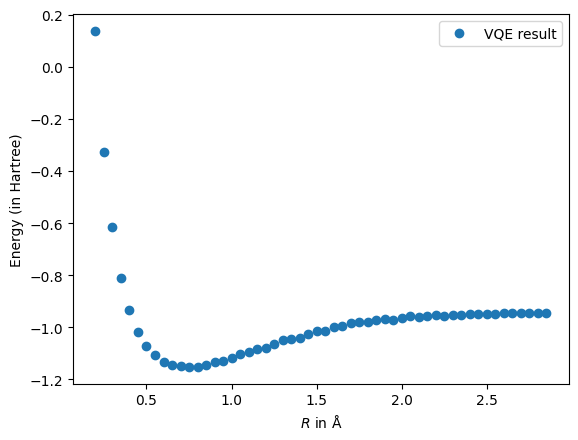

In [27]:
plt.plot(H2_data['R'],H_min_list,'o',label='VQE result')
plt.ylabel('Energy (in Hartree)')
plt.xlabel('$R$ in Å')
plt.legend()

# Check against Analytical Solution and Actual Solution

In [31]:
def analytical_optimal_solution(gvals):
    '''
    Fill in the function tp return the analytical formula for thetaopt and H_opt
    '''
    thetaopt = 0.5*np.arctan( (gvals['g4']+gvals['g5'])/(gvals['g1']-gvals['g2']) )
    
    H_opt = gvals['g0'] - gvals['g3'] + (gvals['g2']-gvals['g1'])*np.cos(2*thetaopt) - (gvals['g4']+gvals['g5'])*np.sin(2*thetaopt)
    
    return thetaopt,H_opt

In [32]:
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
H_analytic_list=[]
theta_analytic_list=[]
for p in range(len(H2_data['R'])):
    gvals={'g0':H2_data['g0'][p],
           'g1':H2_data['g1'][p],
           'g2':H2_data['g2'][p],
           'g3':H2_data['g3'][p],
           'g4':H2_data['g4'][p],
           'g5':H2_data['g5'][p],
            }
    theta_min,H_min=analytical_optimal_solution(gvals)
    H_analytic_list.append(H_min)
    theta_analytic_list.append(theta_min)

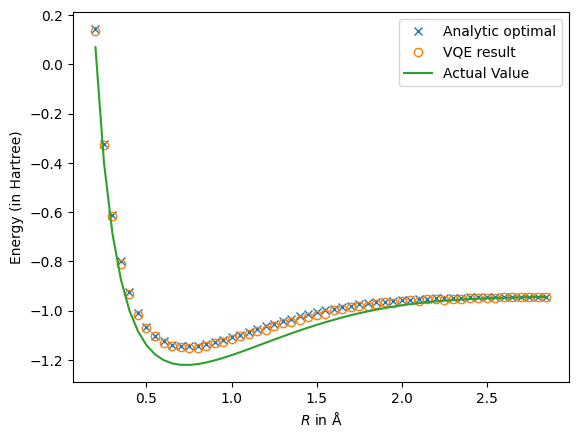

In [33]:
plt.plot(H2_data['R'],H_analytic_list,'x',label='Analytic optimal')
plt.plot(H2_data['R'],H_min_list,'o',mfc='none',label='VQE result')
plt.plot(H2_data['R'],gstate_energies,label='Actual Value')
plt.ylabel('Energy (in Hartree)')
plt.xlabel('$R$ in Å')
plt.legend()

We can see that the analytic optimal result lines up nearly exactly with the VQE exhaustive search result, as it should. Now, both are higher than the actual value, and this is true for all values of R, even if the differential becomes extremely small, as seen on the tail end. The error is the greatest near the optimal bond length. While the energy is overestimated in that well, the observed minimizing bond lengths seem to agree fairly well among the three results.